# 混淆矩阵

通过测试集所有图像预测结果，生成多类别混淆矩阵，评估模型准确度。

同济子豪兄：https://space.bilibili.com/1900783

[代码运行云GPU环境](https://featurize.cn/?s=d7ce99f842414bfcaea5662a97581bd1)：GPU RTX 3060、CUDA v11.2

## 设置Matplotlib中文字体

In [1]:
# # windows操作系统
# plt.rcParams['font.sans-serif']=['SimHei']  # 用来正常显示中文标签 
# plt.rcParams['axes.unicode_minus']=False  # 用来正常显示负号

In [2]:
# Mac操作系统，参考 https://www.ngui.cc/51cto/show-727683.html
# 下载 simhei.ttf 字体文件
# !wget https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220716-mmclassification/dataset/SimHei.ttf

In [1]:
# Linux操作系统，例如 云GPU平台：https://featurize.cn/?s=d7ce99f842414bfcaea5662a97581bd1
# 如果遇到 SSL 相关报错，重新运行本代码块即可
!wget https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220716-mmclassification/dataset/SimHei.ttf -O /environment/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/SimHei.ttf
!rm -rf /home/featurize/.cache/matplotlib

import matplotlib
matplotlib.rc("font",family='SimHei') # 中文字体


--2022-08-12 22:38:42--  https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220716-mmclassification/dataset/SimHei.ttf
Connecting to 172.16.0.13:5848... connected.
Proxy request sent, awaiting response... 200 OK
Length: 10050868 (9.6M) [application/x-font-ttf]
Saving to: ‘/environment/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/SimHei.ttf’

/environment/minico 100%[===================>]   9.58M  17.3MB/s    in 0.6s    

2022-08-12 22:38:42 (17.3 MB/s) - ‘/environment/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/SimHei.ttf’ saved [10050868/10050868]



## 导入工具包

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm

import math
import cv2

import matplotlib.pyplot as plt
%matplotlib inline

## 载入类别名称和ID

In [3]:
idx_to_labels = np.load('idx_to_labels.npy', allow_pickle=True).item()
# 获得类别名称
classes = list(idx_to_labels.values())
print(classes)

['丝瓜', '人参果', '佛手瓜', '冬瓜', '南瓜', '哈密瓜', '木瓜', '甜瓜-伊丽莎白', '甜瓜-白', '甜瓜-绿', '甜瓜-金', '白兰瓜', '羊角蜜', '苦瓜', '西瓜', '西葫芦', '黄瓜']


## 载入测试集预测结果表格

In [4]:
df = pd.read_csv('测试集预测结果.csv')

In [5]:
df.head()

,图像路径,标注类别ID,标注类别名称,top-1-预测ID,top-1-预测名称,top-2-预测ID,top-2-预测名称,top-3-预测ID,top-3-预测名称,top-n预测正确,...,甜瓜-伊丽莎白-预测置信度,甜瓜-白-预测置信度,甜瓜-绿-预测置信度,甜瓜-金-预测置信度,白兰瓜-预测置信度,羊角蜜-预测置信度,苦瓜-预测置信度,西瓜-预测置信度,西葫芦-预测置信度,黄瓜-预测置信度
0,melon17_split/val/丝瓜/109.jpg,0,丝瓜,0.0,丝瓜,2.0,佛手瓜,12.0,羊角蜜,1.0,...,0.002193,0.014018,0.014891,0.003501,0.006260,0.092346,0.001454,0.003925,0.006661,0.001151
1,melon17_split/val/丝瓜/111.jpg,0,丝瓜,0.0,丝瓜,13.0,苦瓜,15.0,西葫芦,1.0,...,0.000567,0.000372,0.000705,0.002064,0.000421,0.072553,0.195918,0.000510,0.144077,0.048166
2,melon17_split/val/丝瓜/113.jpg,0,丝瓜,0.0,丝瓜,5.0,哈密瓜,11.0,白兰瓜,1.0,...,0.022293,0.033744,0.002499,0.009714,0.108798,0.044752,0.009132,0.011167,0.098024,0.035007
3,melon17_split/val/丝瓜/115.jpg,0,丝瓜,3.0,冬瓜,0.0,丝瓜,15.0,西葫芦,1.0,...,0.000888,0.003155,0.003725,0.001007,0.006776,0.002390,0.007951,0.001781,0.100773,0.006788
4,melon17_split/val/丝瓜/120.jpg,0,丝瓜,0.0,丝瓜,15.0,西葫芦,16.0,黄瓜,1.0,...,0.001660,0.000126,0.000372,0.003168,0.000812,0.015668,0.047193,0.000766,0.142601,0.080202


## 生成混淆矩阵

In [6]:
from sklearn.metrics import confusion_matrix

In [7]:
confusion_matrix_model = confusion_matrix(df['标注类别名称'], df['top-1-预测名称'])

In [8]:
confusion_matrix_model

array([[30,  0,  0,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  2,
         2],
       [ 0, 33,  1,  0,  0,  0,  0,  2,  0,  0,  0,  0,  0,  0,  0,  0,
         0],
       [ 1,  1, 25,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,
         1],
       [ 3,  0,  0, 20,  0,  1,  0,  0,  0,  1,  0,  1,  0,  1,  1,  2,
         0],
       [ 0,  0,  0,  0, 31,  1,  2,  0,  0,  0,  0,  0,  0,  0,  2,  0,
         0],
       [ 0,  0,  0,  0,  0, 35,  0,  4,  0,  0,  0,  0,  0,  0,  0,  0,
         0],
       [ 0,  0,  0,  1,  2,  1, 32,  0,  0,  1,  1,  0,  0,  0,  0,  0,
         0],
       [ 0,  1,  0,  1,  0,  1,  0,  8,  2,  0,  1,  3,  0,  0,  1,  0,
         0],
       [ 0,  0,  0,  0,  0,  1,  0,  1, 11,  1,  0,  3,  0,  0,  0,  0,
         0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  2,  4,  0,  0,  0,  0,  1,  1,
         0],
       [ 0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  7,  1,  0,  0,  0,  1,
         0],
       [ 0,  1,  0,  1,  0,  4,  0,  0,  7,  0,  0, 12,  0,  0,  

## 可视化混淆矩阵

In [9]:
import itertools
def cnf_matrix_plotter(cm, classes, cmap=plt.cm.Blues):
    """
    传入混淆矩阵和标签名称列表，绘制混淆矩阵
    """
    plt.figure(figsize=(10, 10))
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    # plt.colorbar() # 色条
    tick_marks = np.arange(len(classes))
    
    plt.title('混淆矩阵', fontsize=30)
    plt.xlabel('预测类别', fontsize=25, c='r')
    plt.ylabel('真实类别', fontsize=25, c='r')
    plt.tick_params(labelsize=18) # 设置类别文字大小
    plt.xticks(tick_marks, classes, rotation=90) # 横轴文字旋转
    plt.yticks(tick_marks, classes)
    
    # 写数字
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > threshold else "black",
                 fontsize=16)

    plt.tight_layout()

    # plt.savefig('混淆矩阵.pdf', dpi=300) # 保存图像
    plt.show()

In [10]:
# 查看所有配色方案
# dir(plt.cm)

In [11]:
# 子豪兄精选配色方案
# Blues
# BuGn
# Reds
# Greens
# Greys
# binary
# Oranges
# Purples
# BuPu
# GnBu
# OrRd
# RdPu

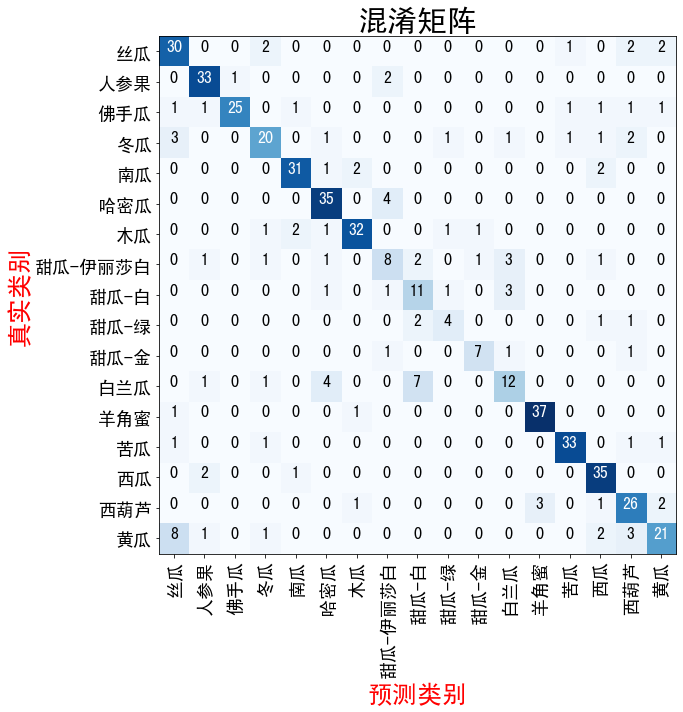

In [12]:
cnf_matrix_plotter(confusion_matrix_model, classes, cmap='Blues')

## 筛选出测试集中，真实为A类，但被误判为B类的图像

In [18]:
true_A = '黄瓜'
pred_B = '丝瓜'

In [19]:
wrong_df = df[(df['标注类别名称']==true_A)&(df['top-1-预测名称']==pred_B)]

In [20]:
wrong_df

,图像路径,标注类别ID,标注类别名称,top-1-预测ID,top-1-预测名称,top-2-预测ID,top-2-预测名称,top-3-预测ID,top-3-预测名称,top-n预测正确,...,甜瓜-伊丽莎白-预测置信度,甜瓜-白-预测置信度,甜瓜-绿-预测置信度,甜瓜-金-预测置信度,白兰瓜-预测置信度,羊角蜜-预测置信度,苦瓜-预测置信度,西瓜-预测置信度,西葫芦-预测置信度,黄瓜-预测置信度
479,melon17_split/val/黄瓜/133.jpg,16,黄瓜,0.0,丝瓜,3.0,冬瓜,6.0,木瓜,0.0,...,0.006425,0.001690,0.005157,0.002255,0.011479,0.015424,0.063012,0.002160,0.064184,0.001499
482,melon17_split/val/黄瓜/144.jpg,16,黄瓜,0.0,丝瓜,16.0,黄瓜,13.0,苦瓜,1.0,...,0.004524,0.007950,0.004482,0.012935,0.005534,0.008646,0.102565,0.047991,0.013023,0.109831
485,melon17_split/val/黄瓜/172.jpg,16,黄瓜,0.0,丝瓜,16.0,黄瓜,15.0,西葫芦,1.0,...,0.000088,0.000090,0.000232,0.000178,0.000433,0.005264,0.003482,0.000750,0.018476,0.439534
491,melon17_split/val/黄瓜/188.jpg,16,黄瓜,0.0,丝瓜,16.0,黄瓜,3.0,冬瓜,1.0,...,0.009742,0.007417,0.000613,0.002655,0.025791,0.011648,0.003741,0.020967,0.016758,0.330668
495,melon17_split/val/黄瓜/25.jpeg,16,黄瓜,0.0,丝瓜,16.0,黄瓜,13.0,苦瓜,1.0,...,0.000926,0.000190,0.000176,0.000591,0.000287,0.003195,0.225065,0.001745,0.001405,0.298895
496,melon17_split/val/黄瓜/30.jpg,16,黄瓜,0.0,丝瓜,16.0,黄瓜,3.0,冬瓜,1.0,...,0.000609,0.000928,0.000352,0.000411,0.000516,0.004271,0.009172,0.002191,0.011348,0.333093
502,melon17_split/val/黄瓜/77.jpg,16,黄瓜,0.0,丝瓜,16.0,黄瓜,3.0,冬瓜,1.0,...,0.000841,0.001137,0.001189,0.000522,0.009219,0.008732,0.032630,0.002888,0.013784,0.266217
504,melon17_split/val/黄瓜/85.jpeg,16,黄瓜,0.0,丝瓜,16.0,黄瓜,14.0,西瓜,1.0,...,0.001656,0.003079,0.007000,0.003215,0.004571,0.070658,0.078680,0.094083,0.021051,0.256325


## 可视化上表中所有被误判的图像

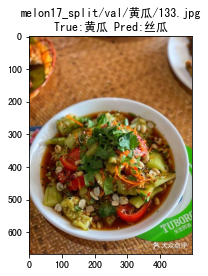

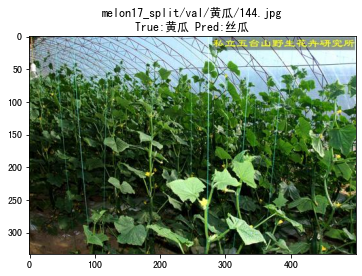

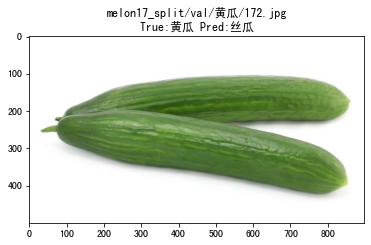

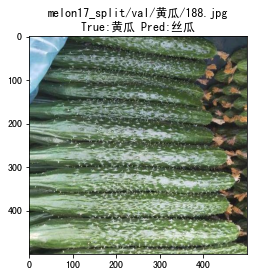

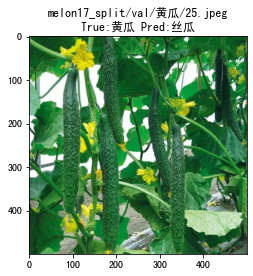

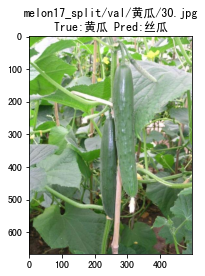

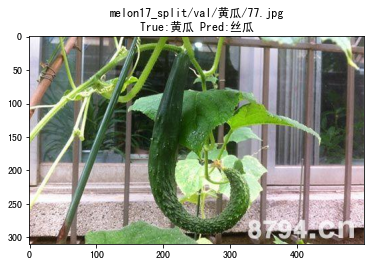

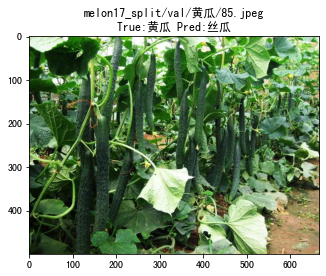

In [21]:
for idx, row in wrong_df.iterrows():
    img_path = row['图像路径']
    img_bgr = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    title_str = img_path + '\nTrue:' + row['标注类别名称'] + ' Pred:' + row['top-1-预测名称']
    plt.title(title_str)
    plt.show()